# CS109b Final Project - Milestone 5 Notebook A
### Mads Groeholdt, Sean McCabe, Josie Mobley, Bridget Sands

## About:
The progression of this notebook is our developement of our final project for CS109b in which we attempt to classify a cat's emotion dependent on its meow (more on this in the problem statement). 

Unfortunately, because of the complexity of the code, **we had to split the notebook into two, in addition to an appendix notebook that contains early EDA and our baseline model.** 

Therefore, this notebook is the **FIRST of the two main notebooks,** containing problem discussion, data description, and our first real try at answer the question further than our bsaeline model.


### Note:
- For implementation of our second advanced method (transfer learning) and the project's overarching conclusions, please see **Notebook B**.
- For early EDA and our baseline model, please see the **Appendix Notebook**.

The table of contents, that outlines the entirety of the notebook, is found below:

## Table of Contents:
1. [Project Context](#context)
    1. [Problem Statement](#state)
    2. [Problem Inspiration](#inspo)
    3. [Problem Plan](#plan)
2. [Data](#data)
    1. [Data Source](#source)
    2. [Data Importation](#import)
    3. [Data Investigation](#look)
    4. [Data Split](#split)
    5. [Data Augmentation](#aug)
    6. [Data Wrap-Up](#wrap)
3. [Appendix Notebook](#append)
    1. [Further EDA](#eda)
    2. [Baseline Model](#base)
4. [CNN 2: The Remake](#remake)
   1. [Idea, Intro](#intro)
   2. [Code](#2code)
   3. [Augmented Extension](#2aug)
   4. [Results](#2res)
5. [Set up of Transfer Learning Notebook/Flow into Notebook B](#tl)

## 1: Project Context <a class="anchor" id="context"></a>
This section provides context relative to the question we are trying to answer and how we are going to do it.

### 1a: Problem Statement <a class="anchor" id="state"></a>
In our project, we are trying to gain understanding of a cat's emotions relative to its meow. 

Specifically, given an audio recording of a cat's meow, we want to be able to identify if it is:
- Angry
- Defence
- Fighting
- Happy
- HuntingMind
- Mating
- MotherCall
- Paining
- Resting
- Warning

To do so, we are going to derive neural network based models.

### 1b: Problem Inspiration <a class="anchor" id="inspo"></a>

Our inspiration in this project is a paper first published Pandeya et all in 2018 (https://www.mdpi.com/2076-3417/8/10/1949?type=check_update&version=3) that attempted to answer the same question. The group attempted different methods, including training a CNN and further implementing classification algorithms on its produced weights, in addition to extending the aforementioned using principles of transfer learning from a pretrained base model. Their technique was quite complex, as they had a significant amount of resources at their disposal. 

### 1c: Problem Plan <a class="anchor" id="plan"></a>
In our attempt to solve the problem, thereby attempting to classify a cat's emotion dependent on its meow, we consider three different tiers of models. We first create a simple benchmark model (detailed in the appendix notebook), then try to recreate Pandeya et all's more advanced CNN without extending it with further classification algorithms, and finally implement our own take on transfer learning. Knowing that the group from the paper had access to significant resources and time to implement their project, we are planning to consider our results on a different scale of success. Our hope is to be able to develop successful models relative to the time and resources availble to us.

Our next step is reading in the data and preparing it for our models.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras import layers, optimizers
import re
import kapre
import torchaudio
from sklearn.model_selection import train_test_split
import librosa
import os
import torch
import IPython.display as ipd
from sklearn.metrics import classification_report
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Shift, Gain
from sklearn.preprocessing import LabelEncoder

2024-05-08 11:52:45.511815: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 11:52:45.561143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 11:52:45.561173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 11:52:45.562305: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 11:52:45.569489: I tensorflow/core/platform/cpu_feature_guar

## 2: Data <a class="anchor" id="data"></a>
Below we describe the data of used in our project, as well as provide code that imports it and prepares it to ultimately be fed into our models.

### 2a: Data Source <a class="anchor" id="source"></a>
We were able to acquire the data we used in this project from the authors of the base paper, Pandeya et all. The group made the dataset available upon request for projects just like ours, that look to extend or expand on it. The group sourcd the data originally by scraping different public audio sources, such as YouTube. 

The data we were given included about ~2700 audio files sorted into their respective emotions, as well as metadata relative to the model their transfer learning method adapted. We explore the data below, first handling its importation. 

### 2b: Data Importation <a class="anchor" id="import"></a>
In order to import the data we utilize the torchaudio library, an extension of the pytorch package. We were also given the original project's augmented data. We ensure that we do not consider these files by defining an additional helper function. We iterate through all of the directories and subdirectories, reading in the datafile names into a list. We then convert the list into a dataframe, that holds not only information about each file's path but the classification label it was given too. When first loading, we noticed that some of the files were stored as 1d arrays instead of 2d arrays. We adapt our code to filter out these problematic arrays. We proceed by creating a function that actually loads in each file and resamples it relative to a 16,000 kHz sampling rate. We chose this sampling rate because it is what the paper uses and is typically used for voice audio. We use this function to check if any of the arrays are 1d instead of 2d and filter out the bad.

In [2]:
# Initialize empty list
data = []

# Define helper function to ignore augmented data
def is_raw_mp3(file_name):
    return bool(re.search(r'\.mp3$', file_name) and not re.search(r'_aug1\(1\)\.mp3$', file_name))

# Iterate through data
for subdir, dirs, files in os.walk("data/"):
    for file in files:
        filepath = os.path.join(subdir, file)
        class_label = os.path.basename(subdir)
        name = file
        
        try:
            # Load data in
            #s = torchaudio.load(filepath)
            if is_raw_mp3(filepath):
                data.append({
                    "name": name,
                    "path": filepath,
                    "emotion": class_label
                })
        except Exception as e:
            print(str(filepath), e)
            pass

In [3]:
# Convert all of data files into dataframe
df = pd.DataFrame(data)
print(f'The dataframe has {len(df.index)} total samples')

# Visualize dataframe 
display(df.head())

The dataframe has 2961 total samples


,name,path,emotion
0,car_extcoll0101.mp3,data/Fighting/car_extcoll0101.mp3,Fighting
1,cat0334.mp3,data/Fighting/cat0334.mp3,Fighting
2,YashLL_Cat0236Fit.mp3,data/Fighting/YashLL_Cat0236Fit.mp3,Fighting
3,YashLL_Cat0911Fit.mp3,data/Fighting/YashLL_Cat0911Fit.mp3,Fighting
4,car_extcoll0297.mp3,data/Fighting/car_extcoll0297.mp3,Fighting


In [4]:
# Define sampling rate
sr = 16000

# Define helper function to read in data and resample to 16000 kHz
def speech_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, sr)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

# Define empty list to store problematic array indices 
drop_indices = []

# Iterate through all rows of df
for index, row in df.iterrows():

    # Call to load function
    audio_arr = speech_to_array_fn(row['path'])

    # Check if right shape, add to problematic list if needed
    if audio_arr.shape[0] != 2:
        drop_indices.append(index)

# Drop problematic indices
df = df.drop(drop_indices)
# Print number of total loaded samples
print(f'The trimmed dataframe has {len(df.index)} total samples')

Note: Illegal Audio-MPEG-Header 0xbf082800 at offset 7536.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


The trimmed dataframe has 2942 total samples


### 2c: Data Investigation <a class="anchor" id="look"></a>
Now that the data has been imported, let's investigate said data to understand its contents.

First, let us inspect a raw file:

In [5]:
# Select random row
idx = np.random.randint(0, len(df))

# Isolate random row
sample = df.loc[idx]
print(f'Raw data of index {idx}:')

# Convert random row to numpy array from soundfile
ex = speech_to_array_fn(sample['path'])
ex

Raw data of index 93:


array([[-3.3149063e-11,  7.1710145e-11,  2.9642080e-10, ...,
         1.5376365e-02, -2.4037376e-02, -5.9737295e-02],
       [-3.3149063e-11,  7.1710145e-11,  2.9642080e-10, ...,
         1.5376365e-02, -2.4037376e-02, -5.9737295e-02]], dtype=float32)

As you can see, when loaded from its path, the audio file is converted into a numeric array. The size of the array varies dependent on the file read in.

Let's continue with our investigation and consider the original audio output. To get a feel for what our audio sounds like, we can use the ipd package to hear an example of the audio:

In [6]:
# Isolate example path
path = sample["path"]
label = sample["emotion"]

# Print information
print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

# Call functions for audio
speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
speech = librosa.resample(np.asarray(speech), orig_sr=sr, target_sr=16_000)
ipd.Audio(data=speech, autoplay=True, rate=sr)

ID Location: 93
      Label: Fighting


We can also visualize the raw data relative to how it prints out as a sound wave:

Text(0.5, 1.0, '93 Sound Plot, Labeled Fighting')

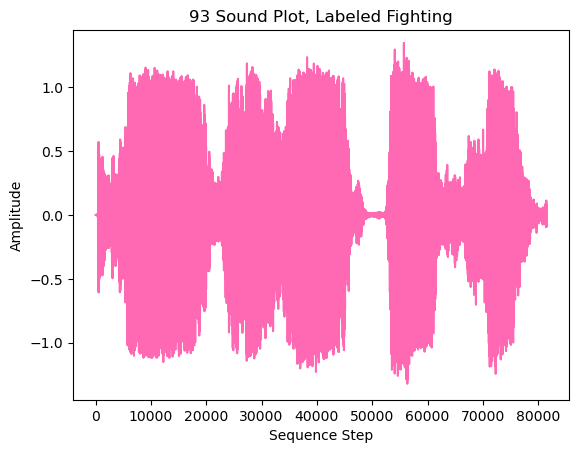

In [7]:
# Plot example
plt.plot(ex[0], color='hotpink')
plt.ylim(-max(ex[0])-.1,max(ex[0])+.1)
plt.xlabel('Sequence Step')
plt.ylabel('Amplitude')
plt.title(f'{idx} Sound Plot, Labeled {label}')

However, just as voices vary by human, regardless of emotion, meows vary by cat. Therefore, not all meows are the same, nor have similar sound waves. Consider the following:

Text(0, 0.5, 'Amplitude')

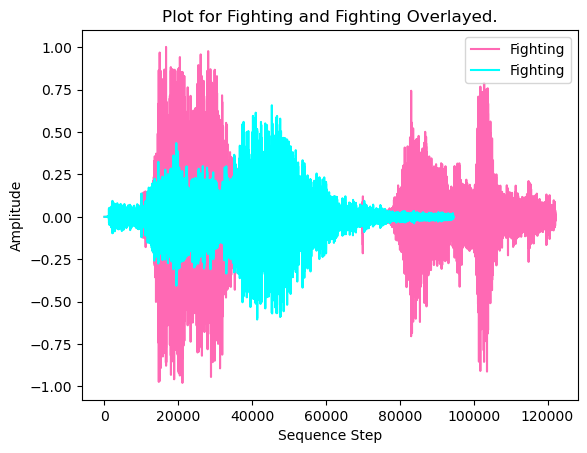

In [8]:
# Isolate first example
ex1 = speech_to_array_fn(df.loc[0, 'path'])
l1 = df.loc[0, 'emotion']
# Isolate second example
ex2 = speech_to_array_fn(df.loc[1, 'path'])
l2 = df.loc[1, 'emotion']

# Plot overlapped examples
plt.plot(ex1[0], color='hotpink', label=l1)
plt.plot(ex2[0], color='cyan', label=l2)
plt.legend()
plt.title(f'Plot for {l1} and {l2} Overlayed.')
plt.xlabel('Sequence Step')
plt.ylabel('Amplitude')

As shown in the above graph, no two meows- even when they have the same emotion label- are the same. That's why we're going to proceed with our models, hoping to derive ways of classification that identify similar characteristics relative to the difference emotions that aren't easily predetermined.

Before we proceed, let's check to see the **balance of our ten classes:**

In [9]:
# Print potential labels
print("Labels: ", df["emotion"].unique())

# Groupby and count by emotion
df.groupby("emotion").count()[["path"]]

Labels:  ['Fighting' 'Mating' 'Resting' 'Happy' 'Defence' 'Warning' 'Paining'
 'Angry' 'HuntingMind' 'MotherCall']


,path
emotion,
Angry,300
Defence,290
Fighting,298
Happy,291
HuntingMind,289
Mating,301
MotherCall,293
Paining,287
Resting,293


As seen above, the 10 different emotions are relatively uniformly represented in the data. That's awesome! 

### 2d: Data Split <a class="anchor" id="split"></a>

Before we proceed, let's split our data into training and validation data, for consistency sake. We use a 20% test split and then a 20% validation split on the remaining data, which gives us the sample sizes given below. We save the files to disk for reproducibility and sharing across group members without having to run preprocessing.

In [10]:
# Define save path
save_path = "data/"

# Split data, stratify by emotion
train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])

# Split data for validation data
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=101, stratify=train_df["emotion"])

# Reset dataframes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

# Save dataframes to csv
train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
validation_df.to_csv(f"{save_path}/validation.csv", sep="\t", encoding="utf-8", index=False)

# Print dataframe shapes
print(f'Train data size: {train_df.shape}')
print(f'Test data size: {test_df.shape}')
print(f'Validation data size: {validation_df.shape}')

Train data size: (1882, 3)
Test data size: (589, 3)
Validation data size: (471, 3)


Just as we did with the overall data, let's confirm that the training, test, and validation dataframes have a relatively equal distribution of emotions:

In [11]:
# Print potential labels
print("Labels: ", train_df["emotion"].unique())

# Groupby and count by emotion
display(train_df.groupby("emotion").count()[["path"]])
display(test_df.groupby("emotion").count()[["path"]])
display(validation_df.groupby("emotion").count()[["path"]])

Labels:  ['Warning' 'Fighting' 'Happy' 'HuntingMind' 'Mating' 'Resting' 'Defence'
 'Angry' 'MotherCall' 'Paining']


,path
emotion,
Angry,192
Defence,186
Fighting,190
Happy,186
HuntingMind,185
Mating,193
MotherCall,187
Paining,184
Resting,187


,path
emotion,
Angry,60
Defence,58
Fighting,60
Happy,58
HuntingMind,58
Mating,60
MotherCall,59
Paining,57
Resting,59


,path
emotion,
Angry,48
Defence,46
Fighting,48
Happy,47
HuntingMind,46
Mating,48
MotherCall,47
Paining,46
Resting,47


Great, by inspection both the train and test dataframes have a relatively uniform distribution of emotions!

### 2e: Data Augmentation <a class="anchor" id="aug"></a>
However, something of note is the size of our data. With roughly ~300 instances of each emotion in the data overall, we don't have an abundance of data. In order to fix this, we can **augment our data.** Augmenting our data means adjusting the data we already have with different actions in order to increase our sampling size. 

In the base paper of this project, they augment their data by randomly applying the following to the original data: 
1. Speed change (range 0.9 to 1)
2. Pitch shifting (range −4 to 4)
3. Dynamic range compression (range 0.5 to 1.1)
4. Insertion of noise (range 0.1 to 0.5)
5. Time shifting (20% in forward or backward direction)

With our data, we do the same, utilizing the audiomentations library in python.

**Note, running this code takes an extremely long time. We view it as unnecessary when grading. However, if you do, please only run it ONCE.**

In [12]:
# Augmenter for training data
augmenter = Compose([
        # Speed change between 0.9 and 1
        TimeStretch(min_rate=0.9, max_rate=1.0, p=0.5),
        # Pitch shift between -4 and 4
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        # Gaussian noise
        AddGaussianNoise(min_amplitude=0.1, max_amplitude=0.5, p=0.5),
        # Time shift within 20% of original clip
        Shift(min_shift=-0.2, max_shift=0.2, shift_unit='fraction', p=0.5),
        # Dynamic Range Compression
        Gain(min_gain_db=-10 * np.log10(1.1), max_gain_db=-10 * np.log10(0.5), p=0.5)
])

In [13]:
%%time
# Define save path
save_augmented_path = "data/augmented/"

# Ensure the directory exists
os.makedirs(save_augmented_path, exist_ok=True)
# Define empty augmented data
augmented_data = []

sample_rate = sr

# Define number of augmentations to be done
n_aug = 1

# Iterate through training data to augment
for index, row in train_df.iterrows():
    for i in range(n_aug):
        arr = speech_to_array_fn(row['path'])
        aug_arr = augmenter(samples = arr, sample_rate = sample_rate)

        # Convert the augmented numpy array back to tensor for saving
        augmented_audio_tensor = torch.tensor(aug_arr)

        #print(augmented_audio_tensor
        
        # Construct a new file path
        augmented_file_path = os.path.join(save_augmented_path, f"{row['name']}_augmented{i}.mp3")
        if index%396 == 0:
            print(augmented_file_path)
        # Save the augmented audio file
        torchaudio.save(augmented_file_path, augmented_audio_tensor, sample_rate)

        # Add to augmented data list
        augmented_data.append({
            'name': f"{row['name']}_augmented{i}",
            'path': augmented_file_path,
            'emotion': row['emotion']
        })

data/augmented/Edit9113Grl.mp3_augmented0.mp3
data/augmented/LastEntry_cat1046Hiss.mp3_augmented0.mp3
data/augmented/cat_youtube01203.mp3_augmented0.mp3
data/augmented/LastEntry_cat1201Fit.mp3_augmented0.mp3
data/augmented/cat_youtube01265.mp3_augmented0.mp3


CPU times: user 7min 53s, sys: 1.5 s, total: 7min 54s
Wall time: 8min 26s


In [14]:
# Store augmented data as dataframe
aug_df = pd.DataFrame(augmented_data)
print(f'{len(aug_df)} augmented sounds')
# Display head
display(aug_df.head())
# Concatenate original data and augmented data
train_aug_df = pd.concat([train_df, aug_df])
# Save augmented data
train_aug_df.to_csv(f"data/train_aug.csv", sep="\t", encoding="utf-8", index=False)
# Print augmented data size
print(f'Augmented train data size: {train_aug_df.shape}')

1882 augmented sounds


,name,path,emotion
0,Edit9113Grl.mp3_augmented0,data/augmented/Edit9113Grl.mp3_augmented0.mp3,Warning
1,car_extcoll0298.mp3_augmented0,data/augmented/car_extcoll0298.mp3_augmented0.mp3,Fighting
2,cat_67.mp3_augmented0,data/augmented/cat_67.mp3_augmented0.mp3,Happy
3,Cat_YoutubeLLT42402 (2).mp3_augmented0,data/augmented/Cat_YoutubeLLT42402 (2).mp3_aug...,HuntingMind
4,YashLL_Cat0223Mating.mp3_augmented0,data/augmented/YashLL_Cat0223Mating.mp3_augmen...,Mating


Augmented train data size: (3764, 3)


We now create HuggingFace Dataset objects from our dataframes in their current state so we can proceed with the two following implemenented methods in order to stay consistent/not cross data:

In [15]:
# Import function necessary
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
train_aug_dataset = Dataset.from_pandas(train_aug_df)
eval_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

print(train_dataset)
print(train_aug_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1882
})
Dataset({
    features: ['name', 'path', 'emotion', '__index_level_0__'],
    num_rows: 3764
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 471
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 589
})


### 2f: Data Wrap-Up  <a class="anchor" id="wrap"></a>
Before proceeding, it is important to note that in addition to the augmentation and preprocessing above, our notebook creates csvs that encapsultes the steps taken and saves the data. We did this because we are **aware of the complexity and longevity of the preprocessing,** and though they also are significant size files, they create a shortcut to access the files rather than re-running the entire notebook. Therefore, **if needed**, rather than **rerunning the entire notebook**, please uncomment and run the following cell:

In [16]:
# # Import necessary function
# train_df = pd.read_csv('data/train.csv')
# train_aug_df = pd.read_csv('data/train_aug.csv')
# validation_df = pd.read_csv('data/validation.csv')
# test_df = pd.read_csv('data/test.csv')

# train_dataset = Dataset.from_pandas(train_df)
# train_aug_dataset = Dataset.from_pandas(train_aug_df)
# eval_dataset = Dataset.from_pandas(validation_df)
# test_dataset = Dataset.from_pandas(test_df)

# print(train_dataset)
# print(train_aug_dataset)
# print(eval_dataset)
# print(test_dataset)

## 3: Appendix Notebook <a class="anchor" id="append"></a>
Below we describe the contents of our appendix notebook, *Milestone_5_Appendix.ipynb* and why said contents are imperative to understand relative to proper comprehension of this project.

### 3a: EDA <a class="anchor" id="eda"></a>
The natural next step of our project is to do further exploratory data analysis (also known as EDA) relative to our data. While we did some about in the data investigation, we kept it brief, not even looking into a single example for each emotion. **However,** there is a simple explanation to this: **our primary submission notebook was too big already.** Therefore, in addition to **this** primary notebook, we also submittied *Milestone_5_Appendix.ipynb*, in which EDA was further explained. In that notebook, we visualize raw data examples for each emotion, in addition to an investigation of the file length distributions in order to find the optimal max length (spoiler alert: its 150,000 sequence steps), and visualizing an example of each emotion in Mel Spectrogram form. However, because that data had significantly different preprocessing steps to the process we decided to pursue, we added it as a supplementary notebook, in order to reduce this notebook's complexity.

### 3b: Baseline Model <a class="anchor" id="base"></a>
Also in the appendix notebook is the first model we developed- our baseline model. It takes in the data that had significantly different preprocessing, as mentioned above. We therefore also included it in the appendix notebook rather than this one in order to preserve complexity. 

However, (though you, our reader, should first go see it in the appendix notebook), our baseline model can be summarized as such:

It has a very simple architecture, with seven total layers, as such:
Input --> Conv2D --> MaxPool2D --> Flatten --> Dense --> Dropout(.3)--> Activation(softmax)


![Baseline architecture](baseline.png)

We trained it on 4 epochs with a 64 batch size, using the adam optimizer, sparse categorical crossentropy as the loss function, and optimized relative to accuracy. The model took a long time to train relative to its complexity, and it **did not** perform well. **It actually predicted worse than a random guess (.1)**. The overall takeaway (as explained in the Appendix notebook, which as mentioned you should look at), was that the true relationship between the meow audio files and classification of cats' emotions is quite complex. 

Thus, we pivoted and continue our project with the following described methods:

## 4: CNN 2: The Remake <a class="anchor" id="remake"></a>
In the following section we first introduce then implement and discuss our second of three overarching methods (the first being the baseline model defined and derived in the Appendix notebook).

### 4a: Idea, Intro <a class="anchor" id="intro"></a>
From the base paper, we gained the idea for this project, as well as the data used. As briefly discussed, however, our approaches are quite different in the capacity to which they make predictions. The base paper explores the use of a pretrained CNN to extract features, as well as a CDBN structure built on top of it. Before exploring transfer learning, as also used paper, we decided to attempt another CNN with a more advanced structure. 

Though the architecture described in the paper is that of the pre-trained model they used that was trained on the million song dataset, we decided to duplicate the architecture and soley train it on the cat audio files to compare and evaluate results. The structure of the CNN is presented to the paper's readers as such:

![remake architecture](remake.png)

However, in our duplication, we add supplements to each layer. We considered each numbered layer to indicate a 2D convolutional layer. In addition to the convolution function calls, we added a max pooling layer to reduce the dimensions of the layers as the paper suggests. We also found that adding a batch normalization call in addition to a dropout call by each layer benefitted our model's performance. Besides the previously mentioned additions, the remainder of our adapted model is almost identical to the architecture outlined in the paper- we record global average pooling of each layer to be used as the final input (for ours, its flattened into a single array with a softmax activation rather than being fed into additional classification algorithms), have the same amount of filters and dimensionality reduction rates, and split the final three layers into segments by how they are distinguished in the paper. The aforementioned segmenation of the final layers create overlapping adjacent frequencies among the segments, as some of the segments include parts of the same information. 

While this is a recreation of the architecture outlined in the paper, it is important to keep in mind it is a recreation of the pretrained architecture of the million song trained model that was utilized in transfer learning form by the authors of the paper. However, as the million song model has proved immensely successful, we decided to pursue its architecture extension.

### 4b: Code <a class="anchor" id="2code"></a>
The following is the code to implement such method. 

First we import and load all of the data from the files as they were in the path. As we had predetermined (in the Appendix notebook!), the max length of all the files is 150,000 sequence steps. Therefore, when we read in the files, we either pad the array with zeros to reach 150,000 sequence steps OR truncate it to be just 150,000. As aforementioned, we use a sampling rate of 16,000 kHz. 

In [17]:
# Helper function to read in and ensure size of files 
def process_audio_file(file_path, max_length=150000, sample_rate=16000):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    if len(audio) < max_length:
        audio = np.pad(audio, (0, max_length - len(audio)), "constant")
    else:
        audio = audio[:max_length]
    return audio

In [18]:
%time
X_train = []
X_val = []
X_test = []

for i in train_df['path'].values:
    X_train.append(process_audio_file(i))

for i in validation_df['path'].values:
    X_val.append(process_audio_file(i))

for i in test_df['path'].values:
    X_test.append(process_audio_file(i))


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


#### Encode ys, split training and test, reshape data:

The default ys are categorical labels, therefore we must encode them in order to put them in the model. To do so, we call a helper function. We then split the data into training and test data, in order to train and evaluate the model. We also reshape the data in order to proper to feed it into the pipeline properly.

In [19]:
# Create a helper function to encode the labels
def encode_labels(labels):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    return labels_encoded

y_train = encode_labels(train_df['emotion'].values)
y_val = encode_labels(validation_df['emotion'].values)
y_test = encode_labels(test_df['emotion'].values)

In [20]:
# Reshape train
t = len(X_train)
X_train = np.array(X_train)
X_train = X_train.reshape((t, 150000, 1))
print(X_train.shape)

# Reshape val
t = len(X_val)
X_val = np.array(X_val)
X_val = X_val.reshape((t, 150000, 1))
print(X_val.shape)

# Reshape test
t = len(X_test)
X_test = np.array(X_test)
X_test = X_test.reshape((t, 150000, 1))
print(X_test.shape)

(1882, 150000, 1)
(471, 150000, 1)
(589, 150000, 1)


#### Define model structure:

For this middle model, we attempted to duplicate the CNN framework relative to the paper we based our entire project on. The paper utilizes the outlined CNN structure and then further takes the weights and puts them through different classification algorithms, including but not limited to random forests, KNN, and SVMs, in order to give the final file classifications. 

However, because of our intentions in extending the transfer learning aspect (detailed in the next section), we did not extend it to the additional classification algorithms.

In [21]:
def cnn2():
    MAX_LENGTH = 150000
    SR = 16000
    
    # Define input
    i = layers.Input(shape=(MAX_LENGTH, 1), name='input')
    
    # Define mel spectrogram layer
    x = kapre.composed.get_melspectrogram_layer(
                                 n_mels=96, pad_end=True,
                                 n_fft=512, win_length=512, hop_length=84,
                                 sample_rate=SR, return_decibel=True,
                                 input_data_format='channels_last',
                                 output_data_format='channels_last')(i)
    
    # Add Noise
    x = layers.GaussianNoise(stddev=0.1)(x)
    
    # First Convolutional Set
    x = layers.BatchNormalization(name='BN_1')(x)
    x = layers.Conv2D(32, (1, 1), (1, 2), activation='relu', padding='same', name='Conv_1')(x)
    x1 = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_1')(x))
    
    x = layers.MaxPooling2D(pool_size=(1, 1), strides=(4,1), name='MaxPool_1')(x)
    x = layers.Dropout(rate=0.2, name='DO_1')(x)
    
    # Second Convolutional Layer
    x = layers.BatchNormalization(name='BN_2')(x)
    x = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_2')(x)
    x2 = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_2')(x))
    
    x = layers.MaxPooling2D(pool_size=(1, 1), strides=(4,1), name='MaxPool_2')(x)
    x = layers.Dropout(rate=0.2, name='DO_2')(x)
    
    # # Third Convolutional Layer
    x = layers.BatchNormalization(name='BN_3')(x)
    
    # Third layer bands
    band1_third = layers.Lambda(lambda x: x[:, :, :5, :], name='Band1_Third')(x)
    band2_third = layers.Lambda(lambda x: x[:, :, 4:9, :], name='Band2_Third')(x)
    band3_third = layers.Lambda(lambda x: x[:, :, 8:13, :], name='Band3_Third')(x)
    band4_third = layers.Lambda(lambda x: x[:, :, 12:16, :], name='Band4_Third')(x)
    
    # Third Convolution 
    band1_third = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_3a')(band1_third)
    band2_third = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_3b')(band2_third)
    band3_third = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_3c')(band3_third)
    band4_third = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_3d')(band4_third)
    
    # GAPS
    x3a = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=False, name='GAP_3a')(band1_third))
    x3b = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=False, name='GAP_3b')(band2_third))
    x3c = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=False, name='GAP_3c')(band3_third))
    x3d = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=False, name='GAP_3d')(band4_third))
    
    # Concatenate bands
    concatenated_features = layers.Concatenate(axis=2)([band1_third, band2_third, band3_third, band4_third])
    x = layers.MaxPooling2D(pool_size=(1, 1), strides=(5,1), name='MaxPool_3')(concatenated_features)
    x = layers.Dropout(rate=0.2, name='DO_3')(x)
    
    # Fourth Convolutional Layer
    x = layers.BatchNormalization(name='BN_4')(x)
    
    # Fourth layer bands
    band1_fourth = layers.Lambda(lambda x: x[:, :, :3, :], name='Band1_Fourth')(x)
    band2_fourth = layers.Lambda(lambda x: x[:, :, 2:5, :], name='Band2_Fourth')(x)
    band3_fourth = layers.Lambda(lambda x: x[:, :, 4:7, :], name='Band3_Fourth')(x)
    band4_fourth = layers.Lambda(lambda x: x[:, :, 6:8, :], name='Band4_Fourth')(x)
    
    # Fourth Convolution 
    band1_fourth = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_4a')(band1_fourth)
    band2_fourth = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_4b')(band2_fourth)
    band3_fourth = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_4c')(band3_fourth)
    band4_fourth = layers.Conv2D(32, (1, 1), (1, 3), activation='relu', padding='same', name='Conv_4d')(band4_fourth)
    
    # GAPS
    x4a = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_4a')(band1_fourth))
    x4b = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_4b')(band2_fourth))
    x4c = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_4c')(band3_fourth))
    x4d = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_4d')(band4_fourth))
    
    # Concatenate bands
    concatenated_features = layers.Concatenate(axis=2)([band1_fourth, band2_fourth, band3_fourth, band4_fourth])
    x = layers.MaxPooling2D(pool_size=(1, 1), strides=(5,1), name='MaxPool_4')(concatenated_features)
    x = layers.Dropout(rate=0.2, name='DO_4')(x)
    
    # Fifth Convolutional Layer
    x = layers.BatchNormalization(name='BN_5')(x)
    
    # Ffifth layer bands
    band1_fifth = layers.Lambda(lambda x: x[:, :, 0:2, :], name='Band1_Fifth')(x)
    band2_fifth = layers.Lambda(lambda x: x[:, :, 1:3, :], name='Band2_Fifth')(x)
    band3_fifth = layers.Lambda(lambda x: x[:, :, 2:4, :], name='Band3_Fifth')(x)
    
    # Fifth Convolution 
    band1_fifth = layers.Conv2D(32, (1, 1), (1, 2), activation='relu', padding='same', name='Conv_5a')(band1_fifth)
    band2_fifth = layers.Conv2D(32, (1, 1), (1, 2), activation='relu', padding='same', name='Conv_5b')(band2_fifth)
    band3_fifth = layers.Conv2D(32, (1, 1), (1, 1), activation='relu', padding='same', name='Conv_5c')(band3_fifth)
    
    # GAPS
    x5a = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_5a')(band1_fifth))
    x5b = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_5b')(band2_fifth))
    x5c = layers.Reshape((1, 32))(layers.GlobalAveragePooling2D(keepdims=True, name='GAP_5c')(band3_fifth))
    
    # Concatenate bands
    concatenated_features = layers.Concatenate(axis=1)([x1, x2, x3a, x3b, x3c, x3d, x4a, x4b, x4c, x4d, x5a, x5b, x5c])
    x = layers.Flatten()(concatenated_features)
    
    # Dense Layers
    o = layers.Dense(10, activation='softmax', name='softmax')(x)
    
    return Model(i, o)

In [23]:
# Display Model
CNNmodel = cnn2()
CNNmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 150000, 1)]          0         []                            
                                                                                                  
 melspectrogram (Sequential  (None, 1786, 96, 1)          0         ['input[0][0]']               
 )                                                                                                
                                                                                                  
 gaussian_noise_1 (Gaussian  (None, 1786, 96, 1)          0         ['melspectrogram[0][0]']      
 Noise)                                                                                           
                                                                                            

#### Model Optimization Parameters:

We decided to use the Adam optimizer for this model. We increased the learning rate from its default of .001 to .01 in order to better fit the data and models. We determined such adjustment by guess and check and because of the complexity of the data we didn't want it to get caught on non-important characteristics.

Because of the multiple categories and complexity of data we used a sparse categorical crossentropy loss function, and optimized relative to the accuracy metric.

After further adjustments and many training iterations, we determined that a batch size of 16, as well as about 20 epochs was good relative to our model's performance. We additionally used a typical 20% validation split in training. Note that we observed an accuracy plateau of about ~.55 relative to the training data, with varying corresponding validation accuracies from about ~.45-.5.

In [24]:
# Define the optimizer
optimizer = optimizers.Adam(learning_rate=0.01)

# Compile the model with the specified optimizer
CNNmodel.compile(optimizer=optimizer,
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [25]:
history = CNNmodel.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=[X_val, y_val])

Epoch 1/20


2024-05-08 12:04:15.234255: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/DO_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-08 12:04:16.041652: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 12:04:16.609083: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-08 12:04:17.117942: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 12:04:18.562307: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa0c8010470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 12:04:18.562347: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capabilit

118/118 [==============================] - 21s 83ms/step - loss: 1.9425 - accuracy: 0.3135 - val_loss: 2.5617 - val_accuracy: 0.0955
Epoch 2/20
118/118 [==============================] - 8s 68ms/step - loss: 1.6777 - accuracy: 0.3836 - val_loss: 2.3127 - val_accuracy: 0.1231
Epoch 3/20
118/118 [==============================] - 8s 68ms/step - loss: 1.6766 - accuracy: 0.4150 - val_loss: 2.0615 - val_accuracy: 0.2166
Epoch 4/20
118/118 [==============================] - 8s 67ms/step - loss: 1.5578 - accuracy: 0.4538 - val_loss: 1.7388 - val_accuracy: 0.3864
Epoch 5/20
118/118 [==============================] - 8s 67ms/step - loss: 1.5791 - accuracy: 0.4309 - val_loss: 1.6726 - val_accuracy: 0.4565
Epoch 6/20
118/118 [==============================] - 8s 67ms/step - loss: 1.5410 - accuracy: 0.4596 - val_loss: 1.5979 - val_accuracy: 0.4501
Epoch 7/20
118/118 [==============================] - 8s 67ms/step - loss: 1.5041 - accuracy: 0.4782 - val_loss: 1.6701 - val_accuracy: 0.4735
Epoch 8/2

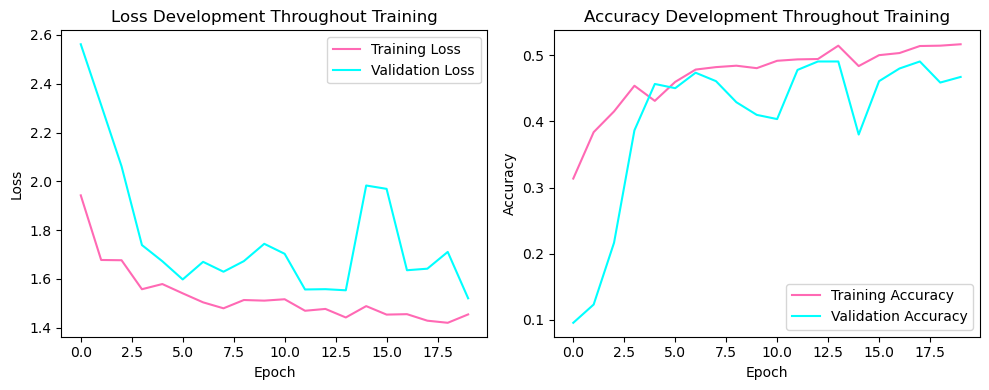

In [32]:
# Define helper function to plot model information
def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs = axs.ravel()
    axs[0].plot(history.history['loss'], label='Training Loss', color='hotpink')
    axs[0].plot(history.history['val_loss'], label='Validation Loss', color='cyan')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Loss Development Throughout Training')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'], label='Training Accuracy', color='hotpink')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Accuracy Development Throughout Training')
    axs[1].legend()
    plt.tight_layout();

# Call function to plot CNN 
plot_model_history(history)

#### Graph Analysis:
Non augmented From the graph of the model trained with the non-augmented data, we can see that the training loss decreases then flattens out after about the 6th epoch. The validation loss is a little less stable with some variations across epochs, however by epoch 20 it has reaches almost as low as the training loss. Both losses start relatively high but end around 1.5, a number indicating the model definitely has room for improvement. 
By looking at the accuracy over epochs we can see it increase quickly throughout the first 5 epochs, then the training accuracy flattens out and the validation also flattens out but continues to maintain a some variation. This plateau shows the model is beginning to fit the train and test datasets better. 

#### Predicting:
Following the fitting of our model, we used it to predict on the original removed testing data. The model produced the following results:

In [26]:
y_preds = CNNmodel.predict(X_test)
y_pred = []
for p in y_preds:
    y_pred.append(np.argmax(p))
label_names = list(sorted(set(train_df['emotion'].values)))

print(classification_report(y_test, y_pred, target_names=label_names))

19/19 [==============================] - 2s 39ms/step
              precision    recall  f1-score   support

       Angry       0.70      0.27      0.39        60
     Defence       0.44      0.79      0.57        58
    Fighting       0.74      0.52      0.61        60
       Happy       0.33      0.33      0.33        58
 HuntingMind       0.46      0.41      0.44        58
      Mating       0.41      0.55      0.47        60
  MotherCall       0.38      0.71      0.49        59
     Paining       0.74      0.25      0.37        57
     Resting       0.83      0.32      0.46        59
     Warning       0.34      0.43      0.38        60

    accuracy                           0.46       589
   macro avg       0.54      0.46      0.45       589
weighted avg       0.54      0.46      0.45       589


#### Interpretation:
The highest precision for our model corresponds to the classification Paining at 0.91, a value much higher than Angry, the second highest precision rate with 0.72. Because the Precision tell us the ratio of correctly predicted positive observations to the total predicted positives, these high values mean that when the model predicts Paining, it is usually correct. The classification with the lowest precision is Warning at 0.39, indicating a high number of false positives for that Category. 
It is important to look at all three values for each class together. Take Angry for instance. After looking at the precision score, of 0.72, we know when the model predicts "Angry", it's usually correct.However, the recall is low at 0.21, which means the model is missing a lot of actual "Angry" cases. Because F1 score is the weighted average of Precision and Recall, it takes both false positives and false negatives into account, so it is a better indicator of overall performance. The F1-score for “Angry” is 0.32, which is actually the lowest across all categories, indicating poor overall performance for the class. The class with the highest F1 score is Defence at 0.68. The high recall of 0.91 shows the model is good at identifying most "Defence" cases. However, it has a relatively low precision is 0.54, suggesting there are a significant number of false positives. 
The overall accuracy of the model 0.55 which is okay. We would love to increase that. 

### 4c: Augmentation Extension <a class="anchor" id="2aug"></a>
As mentioned above, there isn't a ton of data from the original dataset- thats why we augmented it, to extend it. However, the above model was only trained on the single data. We can extend it to be trained on all of the augmented data as well- hopefully the further exposure improves its metrics even further:

In [27]:
# Get values
X_aug = []
for i in train_aug_df['path'].values:
    X_aug.append(process_audio_file(i))

In [28]:
# Encode ys
y_aug = encode_labels(train_aug_df['emotion'].values)

# Reshape
t = len(X_aug)
X_aug = np.array(X_aug)
X_aug = X_aug.reshape((t, 150000, 1))
print(X_aug.shape)

(3764, 150000, 1)


In [29]:
# Construct Model
CNNmodel_aug = cnn2()

# Define the optimizer
optimizer = optimizers.Adam(learning_rate=0.01)

# Compile the model with the specified optimizer
CNNmodel_aug.compile(optimizer=optimizer,
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [30]:
# Fit Model
history_aug = CNNmodel_aug.fit(X_aug, y_aug, batch_size=16, epochs=20, validation_data=[X_val, y_val])

Epoch 1/20


2024-05-08 12:09:09.362422: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/DO_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


236/236 [==============================] - 24s 72ms/step - loss: 2.1407 - accuracy: 0.2325 - val_loss: 2.4255 - val_accuracy: 0.1019
Epoch 2/20
236/236 [==============================] - 16s 66ms/step - loss: 1.9613 - accuracy: 0.2906 - val_loss: 2.1568 - val_accuracy: 0.1762
Epoch 3/20
236/236 [==============================] - 15s 66ms/step - loss: 1.8903 - accuracy: 0.3164 - val_loss: 2.0210 - val_accuracy: 0.2611
Epoch 4/20
236/236 [==============================] - 15s 66ms/step - loss: 1.8710 - accuracy: 0.3284 - val_loss: 1.9561 - val_accuracy: 0.2803
Epoch 5/20
236/236 [==============================] - 15s 66ms/step - loss: 1.8479 - accuracy: 0.3387 - val_loss: 1.7678 - val_accuracy: 0.3715
Epoch 6/20
236/236 [==============================] - 15s 65ms/step - loss: 1.8212 - accuracy: 0.3547 - val_loss: 1.9214 - val_accuracy: 0.3227
Epoch 7/20
236/236 [==============================] - 15s 65ms/step - loss: 1.8201 - accuracy: 0.3549 - val_loss: 1.9325 - val_accuracy: 0.3333
Epo

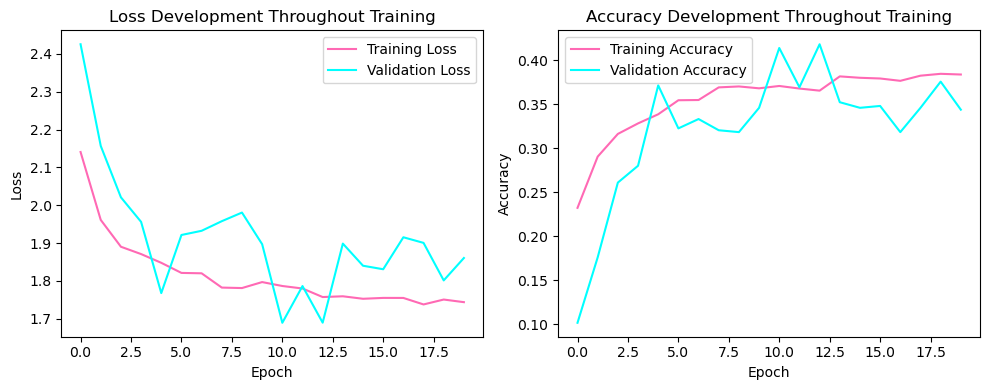

In [33]:
# Call function to plot CNN 
plot_model_history(history_aug)

#### Graph Analysis:

From the graph of the model trained with the augmented data, we can see that the training loss also decreases drastically, then flattens out after about the 8th epoch. The validation loss is less stable with some variations across epochs. Epochs 10-12 are consistently at lower losses than the validation but then it rises and is consistently higher through epoch 20. Both losses start relatively high but end around 1.8/1.9, which indicates improvement and learning, but also room for improvement. By looking at the accuracy over epochs we can see it increase quickly throughout the first 5 epochs, then the training accuracy flattens out and the validation also flattens out but continues to maintain a some variation, oscillating around the training accuracy. This plateau shows the model is beginning to fit the train and test datasets better. The accuracy only gets up to 0.35 which isn’t great. 

#### Predicting:
Following the fitting of our model, we used it to predict on the original removed testing data. The model produced the following results:

In [31]:
# Test augmented model
y_preds_aug = CNNmodel_aug.predict(X_test)
y_pred_aug = []
for p in y_preds_aug:
    y_pred_aug.append(np.argmax(p))

print(classification_report(y_test, y_pred_aug, target_names=label_names))

19/19 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

       Angry       0.82      0.15      0.25        60
     Defence       0.24      0.97      0.38        58
    Fighting       0.77      0.40      0.53        60
       Happy       0.20      0.17      0.18        58
 HuntingMind       1.00      0.03      0.07        58
      Mating       0.32      0.60      0.41        60
  MotherCall       0.46      0.19      0.27        59
     Paining       0.50      0.16      0.24        57
     Resting       0.74      0.34      0.47        59
     Warning       0.28      0.35      0.31        60

    accuracy                           0.34       589
   macro avg       0.53      0.34      0.31       589
weighted avg       0.53      0.34      0.31       589


#### Interpretation:

For the CNN with augmented data, the accuracy still varies a lot across the different classifications. It also remains true that the classes with the highest precision or recall often don’t have the highest f1-score as it is a weighted average of the two values and it is not often a class has a great precision and recall. The category with the highest f1-score was actually fighting with a score of 0.53. This was driven by its high precision at 0.77 and okay recall at 0.4. This tells us that when the model predicts fighting, it is usually correct, however, the lower recall suggests it doesn’t capture all of the instances of fighting. The class with the lowest f1-score is HuntingMind. This category is actually quite interesting because it has a precision of 1, so every time it predicts hunting mind it is correct, but the recall is incredibly low, 0.03, so rarely labels anything hunting mind. The macro average precision (0.53), recall (0.34), and F1-score (0.31) across all classes suggest that overall the model does not perform consistently well. The low recall average indicates the model misses a significant number of positive cases. While the precision is slightly higher, it still indicates that once the model predicts a class, it is only right about 50% of the time. 

### 4d: Results <a class="anchor" id="2aug"></a>
The results of the indivudal models are detailed in the interpretations following their respective classification reports. However, we can further juxtapose them:

Interestingly, the model trained on augmented data performs significantly worse than the model trained with just the basic data. While performance varies slightly each time we run the models, on average the accuracy is .1 lower, a pretty significant amount. Some categories perform similarly across models, while others are vastly different. Across all classes, the model trained with augmented data has a lower f-1 score. The categories that stand out as having the biggest drop in performance are Defence, Hunting mind, and paining. Fighting and Resting are the best in the Augmented model, and they also perform near the top of the non -augmented model. On the other hand Hunting mind and Paining are the worst in the augmented model and they perform above average in the non-augmented model. 
A possible reason for this drop in performance with augmentation could be overfitting to the augmented data. If the data augmentation was too much and changed the data so it wasn’t actually representing data that could’ve been observed, the model might be learning features that are specific to that augmentation and aren’t generalizable to new cat sounds. If this is what’s happening, it would explain why the model doesn’t perform as well on the test set that is actual, non-augmented cat sounds. 

Before concluding this section, it is important to revisit the fact that though this architecture is outlined in the base paper, the authors included it because it is the structure of the pretrained million song dataset model- they did not create this exact model themselves. They used the million song model in order to extract features for each meow which they further fed into classification algorithms to determine the cat's emotion. However, we adapted the architecture to be directly trained on our cat data and directly predict the emotion within the pipeline. Therefore, the fact that we get ~.5 and ~.4 accruacies on the non-augmented and augmented training data, respectively, is quite impressive and should be considered a feat!